# NLP Project 

___

By: Alejandro Garcia, Forest Hensley, and Tarrence Nichols
<br>
Date: May 17, 2022

___

## Executive Summary

### Big Idea

Determine the primary programming language of a GitHub repository by using natural language processing (NLP) techniques on their `README.md`.

### Goals

1. Predict the programming language of a repo by using NLP on the `README.md
2. Conclude if there is a statistically significant difference between `README.md` lengths from the top 3 most common languages.

### Key Findings


### Recomendations



___

## Project Description

In this project, we will attempt to use data from a `README.md` to predict what language a GitHub repo is primarilly coded in.

The following outlines the process taken through the Data Science Pipeline to complete this project.

Plan &#8594; Acquire &#8594; Prepare &#8594; Explore &#8594; Model &#8594; Deliver

___

## Importing the Required Modules

Everything we need to run the code blocks in this notebook are located in the top level directory. To run the code blocks in this report you will need python, numpy, pandas, matplotlib, seaborn, ntlk and sklearn installed on your computer.


In [1]:
# imports.py
from imports import *

# plotting magic
%matplotlib inline
# plotting defaults
plt.rc('figure', figsize=(16, 9))
plt.style.use('seaborn-darkgrid')
plt.rc('font', size=16)
# plt.style.available
# # ^^^ show available seaborn styles

# !!! Warning !!! 
# *** no more warnings ***
import warnings
warnings.filterwarnings("ignore")

# # custom mods
from acquire import *
from prepare import *
from explore import *

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)



___

## Data Acquisition and Preparation

We start by searching github.com for repo's related to the search term "bitcoin". This search is done via GitHub's API and a list is extracted that contains the url path to 100 related repos. We use the list to ascertain the contents of the `README.md` from each repo. The path and language of the repo are gathered additionally.

Now begins the challenge of quantizing communications in the english lanuage. NLP attempts to do just that by utilizing cutting edge computational power. Common parsing techniques are used on the original corpus collected from GitHub. In this project, the contents of an individual `README.md` are treated as a document. Each document is changed to all lower case letters, has punctuation removed, is tokenized, and has stop-words removed as a function of basic cleaning. Further preprocessing includes stemming and lemmetization. Column names are changed for convenience and the all languages other than the top 3 are consolidated into category 'other'. The tidied strings are returned in a single Pandas dataframe.


In [3]:
# For demonstration purposes only, the `data.json` file is being pulled from cache.
# For the initial run on a new machine, please run `python acquire.py` in the terminal prior to running this notebook.

# Results from `acquire.py`, loaded as a Pandas dataframe.
df=pd.read_json('data.json')

# `README.md` contents from above are tidied and returned with a stemmed and lemmtized variant included.
df=words(df)

df.head()

,repo,language,readme,clean,stemmed,lemmatized,contains_python_keywords,contains_cpp_keywords,contains_js_keywords
0,bitcoin/bitcoin,C++,Bitcoin Core integration/staging tree\n=======...,bitcoin core integrationstaging tree httpsbitc...,bitcoin core integrationstag tree httpsbitcoin...,bitcoin core integrationstaging tree httpsbitc...,1,1,0
1,bitcoinbook/bitcoinbook,other,Code Examples: ![travis_ci](https://travis-ci....,code examples traviscihttpstravisciorgbitcoinb...,code exampl traviscihttpstravisciorgbitcoinboo...,code example traviscihttpstravisciorgbitcoinbo...,0,0,0
2,bitcoin/bips,other,"People wishing to submit BIPs, first should pr...",people wishing submit bips first propose idea ...,peopl wish submit bip first propos idea docume...,people wishing submit bips first propose idea ...,1,1,0
3,bitcoinjs/bitcoinjs-lib,other,# BitcoinJS (bitcoinjs-lib)\n[![Github CI](htt...,bitcoinjs bitcoinjslib github cihttpsgithubcom...,bitcoinj bitcoinjslib github cihttpsgithubcomb...,bitcoinjs bitcoinjslib github cihttpsgithubcom...,1,0,1
4,spesmilo/electrum,Python,Electrum - Lightweight Bitcoin client\n=======...,electrum lightweight bitcoin client licence mi...,electrum lightweight bitcoin client licenc mit...,electrum lightweight bitcoin client licence mi...,1,1,0


___

## Exploratory Analysis

With our data acquired and prepared we can now begin to explore the data in order to determine what features of the READMEs might help us identify the main programming language for a Github repository.

In the visualizations below we aim to answer some questions about the data. Details about how these visualization are created can be found in the explore.py file.

### Can the presence of certain keywords be used to identify the main programming language for a repository?

We are interested in knowing if keywords that are unique to a programming language appear in the READMEs. For instance, if the main programming language for a repository is Python are we likely to find terms such as "python", "pip", and "pandas" in the repository. The visualization below will show some of the most frequently occuring words in repositories for each of the top 3 most common programming languages.

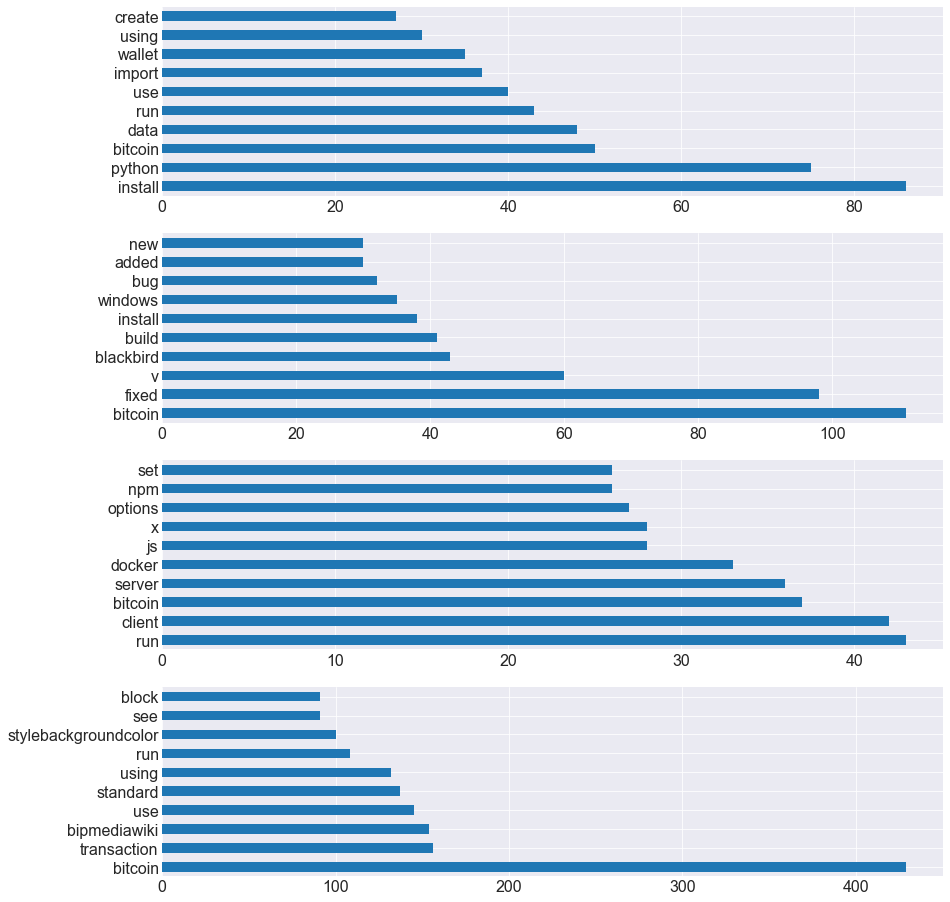

In [4]:
plot_most_frequent_words(df)

### Question 2

2. Is there a statistically significant difference between `README.md` lengths from the top 3 most common languages?

### Question 3

3. Are there bi-grams that are unique to one of the top 3 most common programming languages?

### Question 4

### Key Takeaways



___
## Modeling

In the modeling phase many different models were created to find the best model to predict the language of the repo's `README.md`. Various machine learning algorithms were used with a variety of hyper-parameters. Also different numbers of features were used to determine if the number of features would change the performance of a model. In total 6 different models were produced and evaluated.

In this project we primarily use accuracy to measure the performance of our models since there is a fairly even split between false positives and confirmed languages. In the case when two models have similar accuracy the precision score will help break the tie since we want to be sure of our positive predictions.

### Tidy Data Split

We start by tidying the data for a supervised machine learning model. We take the prepared data from above and isolate the target from the features. In this case, the target, (y), is `'language'` and the feature, (X), is the prepared  `README.md` document. Both, feature and target, are further divided into train, test, and validate dataframes. 


Due to the nuance of the English language, it can be difficult for our model to understand the difference between words like "walked", "walking", or "walk". For a human reader, it is clear we are talking about "when" the action took place, but for the computer, it's easiest to analyze the word's root action, "to walk". In our case, we are trying to see if the meaning of the words in each document can lead us to predict what language they are talking about. 

To better help our models read English we will tokenize each word in the document. Tokenization takes each word from the string literal, and splits it into it's own object. The resulting list of words is appended to our dataframe as the `'clean'` column.

Our tokenized documents are then processed to remove any confusion about words like "walk", from above. There are two methods used to extract the root word, they are stemming and lemmatization. Stemming is a simpler method that removes a words conjugation, leaving the word stem. For example; "resources" becomes "resourc". Lemmatization is similar to stemming in terms of removing conjugation, but lemmmatization attempts to identify the entire root word. For example; "resources" becomes "resource". Both methods are used on our dataset and appended as the "stemmed" and "lemmetized" columns.

Finally, stop words (such as "to", "and", "a", etc...) are removed. While nifty for human readers, these words are unnecessary.




In [26]:
# return train, validate, test splits for supervised machine learning
# the target (y) is isolated from the features (X)
# a modeling set is returned for the cleaned, trimmed, and lemmetized corpora

(X_lem_train,X_lem_validate, X_lem_test,

y_lem_train, y_lem_validate, y_lem_test,

X_stem_train, X_stem_validate, X_stem_test,

y_stem_train, y_stem_validate, y_stem_test,

X_clean_train, X_clean_validate, X_clean_test,

y_clean_train, y_clean_validate, y_clean_test) = model_prep(df)

Below is an example of the feature, (X), and target, (y), data frames for the lematized, training corpus.

In [6]:
print(X_lem_train.head(),'\n')
print(y_lem_train.head())


                                           lemmatized
21  originalbitcoin historical repository satoshi ...
99  bitcoin hardware wallet interface build status...
71  exchange software used intersangocom britcoinc...
97  ruimarinhobitcoincore bitcoincore docker image...
35  zeronet build statushttpstravisciorghellozeron... 

21           C++
99        Python
71         other
97         other
35    JavaScript
Name: language, dtype: object


### Decision Tree Classification Model

This particular corpus lends itself perfectly to a classification model. Therefore, we will use a decision tree to predict which programming language each `README.md` is referencing.  

Classification models are a type of supervised machine learning model that attempts to separate the individual documents, (X), into unique classes. In order for our supervised models to work, we must teach them our programming languages, (y), first. Once our model has been trained, we can use it on an unknown, validation dataset.

There are several methods that a classification algorithm may use. In this project we choose the decision tree approach. A decision tree split's our features, (X), into
two groups. Every iteration of the two groups is measured and given a "gini" score. The higher the "gini" score, the better our model did at putting "Python" documents into the "Python" class and "JavaScript" in it's respective class as well. After the first round of splitting, the process is repeated until every document is labeled.

This approach is very effective at labeling every feature, (X), in fact, we need to be careful of over fitting. To ensure our model is capable of predicting the class of unknown documents, we will use a validate dateset to measure it's consistency.

### NLP Model Analysis




Text(0, 0.5, 'Accuracy [ % ]')

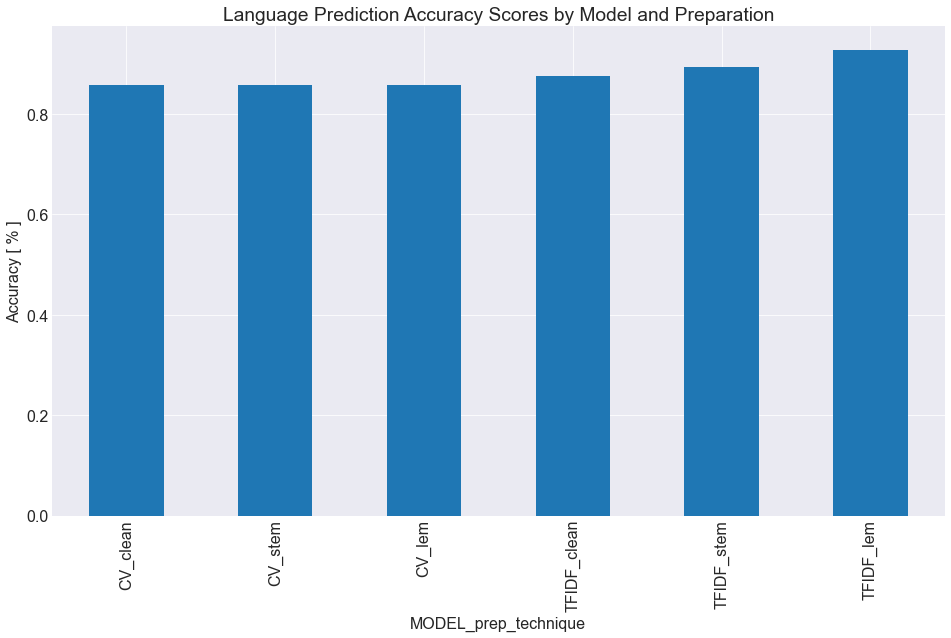

In [28]:
# display the accuracy results for each of the models
# pulls the score from prepare.py
dec_tree_training_scores=classi_bow(X_lem_train,y_lem_train,X_stem_train,y_stem_train,X_clean_train,y_clean_train)
# plot accuracy scores
dec_tree_training_scores.plot.bar()
plt.title('Language Prediction Accuracy Scores by Model and Preparation')
plt.xlabel('MODEL_prep_technique')
plt.ylabel('Accuracy [ % ]')


___

## Key Takeaways and Recommendations



___

## Next Steps